# Word2Vec for Text Classification

In this short notebook, we will see an example of how to use a pre-trained Word2vec model for doing feature extraction and performing text classification.

We will use the sentiment labelled sentences dataset from UCI repository
http://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

The dataset consists of 1500 positive, and 1500 negative sentiment sentences from Amazon, Yelp, IMDB. Let us first combine all the three separate data files into one using the following unix command:

```cat amazon_cells_labelled.txt imdb_labelled.txt yelp_labelled.txt > sentiment_sentences.txt```

For a pre-trained embedding model, we will use the Google News vectors.
https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM

Let us get started!

In [11]:
#basic imports
import os
from time import time

#pre-processing imports
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

#imports related to modeling
import numpy as np
import pandas as pd
from gensim.models import Word2Vec, KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#Word2vector by another lib (DNN)

In [34]:
from gensim.models import Word2Vec, KeyedVectors #To load the model
import warnings
warnings.filterwarnings('ignore') #ignore any generated warnings
import numpy as np
# load model
path='https://github.com/practical-nlp/practical-nlp/blob/master/Ch3/Models/word2vec_cbow.bin?raw=true'
model_new = KeyedVectors.load_word2vec_format(path, binary=True)

In [35]:
model_new

In [37]:
# Inspect the model
word2vec_vocab_new = model_new.vocab.keys()
word2vec_vocab_lower_new = [item.lower() for item in word2vec_vocab_new]
print(len(word2vec_vocab_new))

161018


Model nay chi co 161,000 tu, kem hon nhieu model cua google la 3,000,000

# Word2vector by googlenew

In [4]:
#download google new vectors (other tool than word2vector)
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

/bin/bash: brew: command not found
--2020-08-01 04:02:29--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.129.237
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.129.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  32.0MB/s    in 50s     

2020-08-01 04:03:20 (31.2 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [6]:
path_to_model = '/content/GoogleNews-vectors-negative300.bin.gz'
#Load W2V model. This will take some time. 
%time w2v_model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
print('done loading Word2Vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 1min 53s, sys: 4.09 s, total: 1min 57s
Wall time: 1min 57s
done loading Word2Vec


In [19]:
training_data_path = '/content/drive/My Drive/Data/NLP/sentiment_all.txt'
#Read text data, cats.
#the file path consists of tab separated sentences and cats.
texts = []
cats = []
fh = open(training_data_path)
for line in fh:
    text, sentiment = line.split("\t")
    texts.append(text)
    cats.append(sentiment)


In [20]:
# Inspect the model
word2vec_vocab = w2v_model.vocab.keys()
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]
print(len(word2vec_vocab))

3000000


In [21]:
#Inspect the dataset
print(len(cats), len(texts))
print(texts[1])
print(cats[1])

3000 3000
Good case, Excellent value.
1



In [26]:
#Preprocessing our models vocabulary to make better visualizations
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
#preprocess the text.
def preprocess_corpus(texts):
    mystopwords = set(stopwords.words("english"))
    def remove_stops_digits(tokens):
        #Nested function that lowercases, removes stopwords and digits from a list of tokens
        return [token.lower() for token in tokens if token not in mystopwords and not token.isdigit()
               and token not in punctuation]
    #This return statement below uses the above function to process twitter tokenizer output further. 
    return [remove_stops_digits(word_tokenize(text)) for text in texts]
    #Tach rieng tung tu trong cau (word_tokenize) sau do lowercases, bo dau,stopword 
    #va so ra khoi tung tu

texts_processed = preprocess_corpus(texts)
print(len(cats), len(texts_processed))
print(texts_processed[1])
print(cats[1])

3000 3000
['good', 'case', 'excellent', 'value']
1



In [31]:
texts_processed[:5]

[['so', 'way', 'plug', 'us', 'unless', 'i', 'go', 'converter'],
 ['good', 'case', 'excellent', 'value'],
 ['great', 'jawbone'],
 ['tied', 'charger', 'conversations', 'lasting', 'minutes.major', 'problems'],
 ['the', 'mic', 'great']]

In [53]:
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists: # trich tung cau sentiments trong toan van ban
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0
        # tach tung tu trong 1 cau sentiments, chuyen sang vector kich thuoc 300
        for token in tokens: #['so', 'way', 'plug', 'us', 'unless', 'i', 'go', 'converter'],
            if token in w2v_model: #'so'...
                feat_for_this += w2v_model[token] # 300 dimension
                count_for_this +=1
        feats.append(feat_for_this/count_for_this)    
        # cong tat ca token vector cua tung tu trong 1 sentiment va 
        #chia tong lay trung binh     
    return feats # return tung sentiment da duoc vector (300 dim)

train_vectors = embedding_feats(texts_processed)

In [55]:
print(len(train_vectors))
print(len(train_vectors[0]))
# train_vectors chua 3000 tu sentiment da duoc convert sang vector 300 dim

3000
300


# DNN fix bug for train/test split and classification

## Clean data

In [103]:
train_vectors_df=pd.DataFrame(train_vectors)
train_vectors_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.021805,-0.023468,-0.012323,0.077515,-0.088196,0.070930,-0.010033,-0.075729,0.082336,0.057972,-0.073334,-0.118927,-0.122688,-0.087128,-0.136826,0.062119,0.135101,0.089153,0.032700,-0.051884,0.050720,0.115067,0.087708,0.046097,0.115997,0.074646,-0.053223,0.003174,0.038960,-0.000963,-0.031982,0.090088,-0.081940,-0.036938,-0.041351,-0.024971,0.025858,-0.040695,0.027710,0.074799,...,-0.000793,0.009430,-0.118835,0.055084,-0.012728,0.103458,0.026917,-0.076813,-0.062988,-0.026306,0.024513,0.041832,0.065262,0.108101,0.064667,-0.117340,-0.060623,-0.188507,-0.071335,-0.021705,-0.055595,-0.043552,0.024734,0.102722,0.052923,-0.022774,-0.005280,-0.163971,0.059113,0.065811,-0.002777,0.200783,-0.159241,0.056152,-0.044449,0.066162,-0.081963,-0.027138,-0.020218,-0.012622
1,-0.008728,0.038536,-0.037689,0.037628,0.028809,0.133072,0.104202,0.012512,0.081543,0.196411,-0.115005,-0.107529,0.068542,0.103210,-0.134033,0.164795,0.115723,0.092094,-0.059814,-0.100784,0.021362,-0.035645,-0.050537,0.094482,0.137604,0.041683,-0.105106,0.072327,-0.006805,0.044296,-0.012909,-0.116348,0.121216,-0.000488,0.149689,0.167114,0.041199,-0.017685,-0.041260,-0.036560,...,-0.029236,0.029541,-0.143555,0.021240,0.074188,0.059509,-0.015442,-0.144836,-0.082108,-0.081055,0.032013,0.058167,0.023254,-0.019363,0.031860,0.058075,0.086731,-0.123718,-0.131104,0.055725,0.019104,0.010284,0.087404,0.148438,-0.115295,-0.013916,-0.064751,-0.021637,-0.042667,-0.012558,0.024460,0.058664,-0.113159,-0.009438,0.023499,0.132477,0.000320,-0.120605,-0.032248,-0.031235
2,0.013550,0.137695,-0.085022,0.136475,-0.062500,0.126953,0.119873,0.034424,0.105591,0.085693,0.069214,-0.204102,-0.174805,0.014648,-0.057495,0.013428,-0.018066,0.282227,-0.061157,-0.183105,0.011466,-0.052734,0.021297,0.144775,-0.082520,-0.003906,-0.175049,-0.037964,0.219604,-0.019043,-0.147217,0.035767,0.112549,-0.046875,0.119873,-0.130463,-0.133789,0.123199,0.097969,0.201660,...,0.190430,-0.050781,-0.310059,0.272278,0.068237,0.250732,-0.063477,-0.370361,0.058411,-0.029327,-0.262695,0.319336,0.083527,-0.032532,0.183350,-0.054932,0.035156,-0.147949,-0.265625,-0.128296,0.155518,-0.079834,-0.041809,-0.029541,-0.166077,0.059265,-0.144531,0.042297,0.101074,-0.115295,0.026001,0.096191,-0.091553,0.105835,-0.081177,0.123535,0.049683,-0.166504,0.034485,-0.098877
3,-0.031543,0.064844,-0.028577,0.068555,-0.035107,-0.016791,0.007568,-0.080078,0.246140,0.075586,-0.108691,-0.031006,-0.105176,0.057227,0.104785,0.032568,0.209521,0.152539,0.005859,-0.112531,0.039551,0.065967,-0.044873,0.008838,-0.028918,0.082715,-0.191895,0.098730,0.035083,-0.159668,-0.052832,-0.004248,-0.016187,0.047314,0.062176,-0.066016,0.128503,-0.030957,-0.033203,0.013525,...,-0.010013,0.163110,-0.158057,-0.052100,-0.020117,0.181372,0.044727,-0.089648,-0.139404,0.050195,0.097314,0.038574,0.048340,-0.043213,0.095020,-0.058008,-0.109491,-0.022559,0.015045,-0.093066,0.137183,-0.095215,0.054492,0.057715,-0.061719,-0.134814,0.035596,0.047705,0.024121,-0.021048,0.056494,0.126758,0.044019,-0.022070,-0.120947,0.042334,-0.157031,-0.139941,0.023798,0.066406
4,0.043498,-0.009603,-0.090535,0.072144,0.026489,-0.030762,0.028158,-0.038411,0.039469,0.102498,-0.114746,-0.093424,0.142314,-0.089844,-0.008952,0.062826,0.069316,0.208252,0.016846,-0.202271,0.142613,0.215820,-0.008382,-0.002556,-0.059245,0.049927,-0.074870,0.133708,0.086421,-0.049479,-0.181722,0.123820,-0.024495,0.056773,-0.002035,-0.064087,-0.012044,-0.024394,-0.028437,0.025391,...,-0.122518,-0.065918,-0.095378,-0.011515,-0.035563,0.112630,-0.098928,-0.035238,-0.088664,0.007711,-0.134033,0.058512,-0.069275,-0.005737,0.138265,-0.068970,-0.001709,-0.077393,-0.168945,-0.028768,0.082438,-0.040482,0.040955,0.033366,0.122030,-0.052450,-0.039225,-0.063965,-0.07

In [106]:
train_vectors_df.isnull().sum()

0      2
1      2
2      2
3      2
4      2
      ..
295    2
296    2
297    2
298    2
299    2
Length: 300, dtype: int64

In [107]:
train_vectors_df[train_vectors_df.isnull().any(axis=1)]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
1125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
train_vectors_df.dropna(inplace=True)
train_vectors_df.shape

(2998, 300)

In [132]:
cats_new=[a.replace('\n','') for a in cats]
cats_df=pd.DataFrame(cats_new)
cats_df.head()

,0
0,0
1,1
2,1
3,0
4,1


In [133]:
cats_df.isnull().sum()

0    0
dtype: int64

In [136]:
cats_df=cats_df.iloc[train_vectors_df.index]
cats_df.shape

(2998, 1)

In [139]:
X_train, X_test, y_train, y_test= train_test_split(train_vectors_df, cats_df,
                                                                test_size=0.3,random_state=42,
                                                                stratify=cats_df)
print(X_train.shape)
print(X_test.shape)

(2098, 300)
(900, 300)


In [143]:
X_train.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
295    0
296    0
297    0
298    0
299    0
Length: 300, dtype: int64

In [144]:
#Take any classifier (LogisticRegression here, and train/test it like before.
classifier = LogisticRegression(random_state=1234)
classifier.fit(X_train, y_train)
y_preds = classifier.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       450
           1       0.83      0.84      0.84       450

    accuracy                           0.84       900
   macro avg       0.84      0.84      0.84       900
weighted avg       0.84      0.84      0.84       900



Not bad. With little efforts we got 81% accuracy. Thats a great starting model to have!!

In [152]:
#Load sklearn
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

from sklearn import preprocessing as pp
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

from sklearn.metrics import log_loss 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score,balanced_accuracy_score
from sklearn.metrics import average_precision_score 

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, NMF

#ML normal ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#ML ensembles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
#Special
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier


In [148]:
# Creating a list of the classifiers
classifiers = {
    'KNN':KNeighborsClassifier(),   #verylong 600s with this data set ?  
    'LR':LogisticRegression(),
    'LDA':LinearDiscriminantAnalysis(), 
    'CART':DecisionTreeClassifier(), #Boosting is more suitable
    'NB':GaussianNB(),
    'SVC':SVC(), #Very Long
    #Ensemble:
    #'RF':RandomForestClassifier(), #Bagging (very long)
    #'AB':AdaBoostClassifier(),  #Boosting
    #'GBM':GradientBoostingClassifier(), #Boosting
    #'ET':ExtraTreesClassifier(), #Bagging (very long)
    #New from Matt cookbook
    'XGB':XGBClassifier(), #New Boosting
    'LGBM':LGBMClassifier(), #New Boosting   
}

In [149]:
#Cross validate
import time
num_folds = 5
seed = 7

scoring = {'accuracy' : make_scorer(balanced_accuracy_score), 
           'precision' : make_scorer(precision_score,average='macro'),
           'recall' : make_scorer(recall_score,average='macro'), 
           'f1' : make_scorer(f1_score,average='macro')}

names = []
train_acc=[]
train_rec_macro=[]
train_prec_macro=[]
train_f1_macro=[]
test_acc=[]
test_rec_macro=[]
test_prec_macro=[]
test_f1_macro=[]
fit_time=[]
time_=[]

for name, model in classifiers.items():
  print(name)
  start=time.time()
  estimator = model
  
  kfold = StratifiedKFold(n_splits=num_folds, random_state=seed,shuffle=True)
  cv_results = cross_validate(estimator, X_train, y_train, cv=kfold, scoring=scoring,
                              return_train_score=True,
                              return_estimator=True
                              )

  # Time :
  time_cal=time.time() - start
  print('time : %0.3f' % (time_cal),'\n')
  
  #results.append(cv_results) # array of values
  names.append(name)
  train_acc.append(cv_results['train_accuracy'].mean())
  train_rec_macro.append(cv_results['train_recall'].mean())
  train_prec_macro.append(cv_results['train_precision'].mean())
  train_f1_macro.append(cv_results['train_f1'].mean())

  test_acc.append( cv_results['test_accuracy'].mean())
  test_rec_macro.append(cv_results['test_recall'].mean())
  test_prec_macro.append(cv_results['test_precision'].mean())
  test_f1_macro.append(cv_results['test_f1'].mean())

  fit_time.append(cv_results['fit_time'].mean())
  time_.append(time_cal)

  #print(cv_results.keys())
  print("%s: train_acc: %0.2f train_rec_macro: %0.2f train_prec_macro: %0.2f \
  test_acc: %0.2f test_rec_macro: %0.2f test_prec_macro: %0.2f \
  fit_time: %0.2f" % 
       (name, cv_results['train_accuracy'].mean(),cv_results['train_recall'].mean(),cv_results['train_precision'].mean(),
       cv_results['test_accuracy'].mean(),cv_results['test_recall'].mean(),cv_results['test_precision'].mean(),
       cv_results['fit_time'].mean()))
 # print(name, cv_results['train_acc'].mean(),cv_results['train_rec_micro'],cv_results['train_prec_macro'],
  #      cv_results['test_acc'],cv_results['test_rec_micro'],cv_results['test_prec_macro'],
   #      cv_results['score_time'],cv_results['fit_time']) 


LR
time : 0.663 

LR: train_acc: 0.86 train_rec_macro: 0.86 train_prec_macro: 0.86   test_acc: 0.82 test_rec_macro: 0.82 test_prec_macro: 0.83   fit_time: 0.04
LDA
time : 1.236 

LDA: train_acc: 0.88 train_rec_macro: 0.88 train_prec_macro: 0.88   test_acc: 0.79 test_rec_macro: 0.79 test_prec_macro: 0.79   fit_time: 0.18
CART
time : 3.055 

CART: train_acc: 1.00 train_rec_macro: 1.00 train_prec_macro: 1.00   test_acc: 0.62 test_rec_macro: 0.62 test_prec_macro: 0.62   fit_time: 0.55
NB
time : 0.321 

NB: train_acc: 0.81 train_rec_macro: 0.81 train_prec_macro: 0.82   test_acc: 0.79 test_rec_macro: 0.79 test_prec_macro: 0.79   fit_time: 0.01
SVC
time : 8.690 

SVC: train_acc: 0.91 train_rec_macro: 0.91 train_prec_macro: 0.91   test_acc: 0.84 test_rec_macro: 0.84 test_prec_macro: 0.84   fit_time: 0.78
RF
time : 11.044 

RF: train_acc: 1.00 train_rec_macro: 1.00 train_prec_macro: 1.00   test_acc: 0.80 test_rec_macro: 0.80 test_prec_macro: 0.80   fit_time: 2.10
AB
time : 20.370 

AB: train_ac

In [150]:
df_results_val=pd.DataFrame(list(zip(names,test_acc,test_rec_macro,test_prec_macro,test_f1_macro,
                                     train_acc,train_rec_macro,train_prec_macro,train_f1_macro,
                                     fit_time,time_)),
                  columns=['Names','test_acc','test_rec_macro','test_prec_macro','test_f1_macro',
                           'train_acc','train_rec_macro','train_prec_macro','train_f1_macro',
                           'fit_time','time'])
df_results_val=df_results_val.sort_values(by='test_f1_macro',ascending=False)
df_results_val

,Names,test_acc,test_rec_macro,test_prec_macro,test_f1_macro,train_acc,train_rec_macro,train_prec_macro,train_f1_macro,fit_time,time
4,SVC,0.836482,0.836482,0.837124,0.836417,0.913952,0.913952,0.914331,0.913944,0.783529,8.689782
0,LR,0.824571,0.824571,0.825394,0.824482,0.863553,0.863553,0.863676,0.863548,0.041317,0.663476
5,RF,0.802155,0.802155,0.802875,0.802054,0.999642,0.999642,0.999643,0.999643,2.097168,11.043561
10,LGBM,0.800720,0.800720,0.801671,0.800544,0.999642,0.999642,0.999643,0.999643,6.137467,31.151726
7,GBM,0.798337,0.798337,0.799325,0.798172,0.980456,0.980456,0.980476,0.980458,18.804922,94.377216
8,ET,0.796890,0.796890,0.798162,0.796682,0.999642,0.999642,0.999643,0.999643,0.560878,3.420607
3,NB,0.791645,0.791645,0.793935,0.791274,0.813232,0.813232,0.815839,0.812878,0.010034,0.320806
1,LDA,0.791212,0.791212,0.792138,0.791071,0.877255,0.877255,0.877479,0.877245,0.176971,1.235551
9,XGB,0.789758,0.789758,0.790955,0.789561,0.974852,0.974852,0.974936,0.974856,3.503091,17.948454
6,AB,0.759752,0.759752,0.760579,0.759566,0.853786,0.853786,0.853858,0.853781,3.937424,20.370371


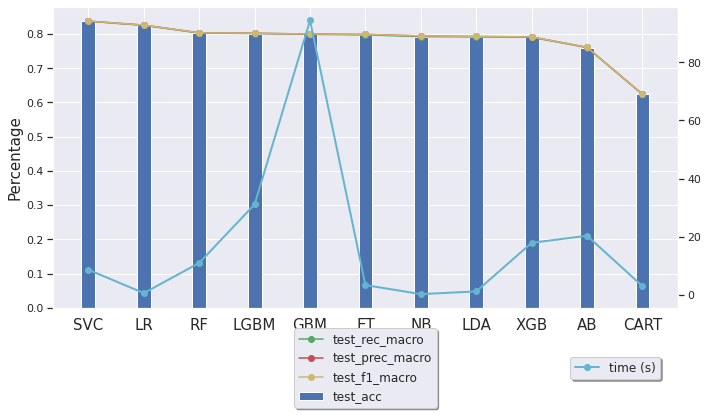

In [153]:
# Define name:
name=df_results_val['Names']
test_acc=df_results_val['test_acc']
test_rec_micro=df_results_val['test_rec_macro']
test_prec_macro=df_results_val['test_prec_macro']
test_f1_macro=df_results_val['test_f1_macro']
time = df_results_val['time']
# Plot:
x = np.arange(len(name))
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x, test_acc, color = 'b', width = 0.25,label='test_acc')
rects2 = ax.plot(x, test_rec_micro, color = 'g',marker='o',label='test_rec_macro')
rects3 = ax.plot(x, test_prec_macro, color = 'r',marker='o',label='test_prec_macro')
rects4 = ax.plot(x, test_prec_macro, color = 'y',marker='o',label='test_f1_macro')

ax2 = ax.twinx()
ax2.plot(x,time,color ='c',marker='o',lw=2,label='time (s)')
ax2.secondary_yaxis('right')

ax.set_xticks(x)
ax.set_xticklabels(name,fontsize=15)
ax.set_ylabel('Percentage',fontsize=15)
ax2.set_ylabel('Time',fontsize=15)
#plt.gca().legend(loc ='center',bbox_to_anchor=(0.5, -0.2))
legend1=ax.legend(loc='center',bbox_to_anchor=(0.5, -0.2),shadow=True, fontsize='medium')
legend2=ax2.legend(loc='center',bbox_to_anchor=(0.9, -0.2),shadow=True, fontsize='medium')

plt.axis('off')
fig.tight_layout()
plt.show()